In [1]:
import os
import json
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

import contextily as cx


/Users/andreaparra/Virtual-Envs/python_3.9/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [17]:
#first get alerts with flooding
paths = []
not_found = []
count = 0
base_dir = "data/11-04-2023"

base_path = base_dir
for hour in os.listdir(base_path):
    for minute in os.listdir(os.path.join(base_path, hour)):
        for file_name in os.listdir(os.path.join(base_path, hour, minute)):
            path = os.path.join(base_path, hour, minute, file_name, f"{file_name}.json")
            kml_path = os.path.join(base_path, hour, minute, file_name, f"{file_name}.kml")
            if os.path.exists(path):
                f = open(path)
                data = json.load(f)
                flooded = data["hasFlooding"]

                if flooded:
                    paths.append(kml_path)
            else:
                not_found.append(path)
            count += 1

print(f"From {count} alerts, found: {len(paths)} floods, and {len(not_found)} missing json")

From 2759 alerts, found: 142 floods, and 9 missing json


In [57]:
paths

['data/11-04-2023/11/03/00/f7225064b9e3439a9bc37f65cb600152/f7225064b9e3439a9bc37f65cb600152.kml',
 'data/11-04-2023/11/03/00/d9b9f42014fe4be89e0481598037628a/d9b9f42014fe4be89e0481598037628a.kml',
 'data/11-04-2023/11/03/00/f3160f5c25524250962e27d30949e995/f3160f5c25524250962e27d30949e995.kml',
 'data/11-04-2023/11/03/00/689f842402314ba69383cfa441b5497c/689f842402314ba69383cfa441b5497c.kml',
 'data/11-04-2023/11/03/00/9ef42286fe2d4f99823eda9d671e45f6/9ef42286fe2d4f99823eda9d671e45f6.kml',
 'data/11-04-2023/11/03/00/dc928e5b159b4a15855db1f0c47eb9ce/dc928e5b159b4a15855db1f0c47eb9ce.kml',
 'data/11-04-2023/11/03/00/8f5dbf67ddd94a0ca7eaa0115d2dcab8/8f5dbf67ddd94a0ca7eaa0115d2dcab8.kml',
 'data/11-04-2023/11/03/00/2b3de78980a8451b9900f6588dd1b01c/2b3de78980a8451b9900f6588dd1b01c.kml',
 'data/11-04-2023/11/03/00/f925a50e83e04398a8bbcc20f51496d6/f925a50e83e04398a8bbcc20f51496d6.kml',
 'data/11-04-2023/11/03/30/c54b2c144ddc4b10b6262c4cd65f2ab2/c54b2c144ddc4b10b6262c4cd65f2ab2.kml',
 'data/11-

In [42]:
brazil_lower_left = [-28.93576585672869, -70.90469836359233]
brazil_upper_right = [5.696972115053628, -33.84640810546731]
la_map = os.path.join("latam_shp", "vc965bq8111.shp")

not_found = []
alert_in_brazil = []

centroids = []
index = []

for idx, path in enumerate(paths):
    if not os.path.exists(path):
        not_found.append(path)
        continue
    
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    gdf = gpd.read_file(path, driver='KML')
    aoi_centroid = gdf.loc[gdf["Name"] == "aoi_polygon", "geometry"].representative_point().values[0]
    centroids.append(aoi_centroid)
    index.append(idx)
    lon = int(aoi_centroid.x)
    lat = int(aoi_centroid.y)

    if lon > brazil_lower_left[1] and lon < brazil_upper_right[1]:
        if lat > brazil_lower_left[0] and lat < brazil_upper_right[0]:
            alert_in_brazil.append(path)

gdf = gpd.GeoDataFrame(geometry=centroids)
gdf.head()

,geometry
0,POINT (-65.26404 -11.15219)
1,POINT (-44.13880 -4.07454)
2,POINT (-42.27731 -4.17939)
3,POINT (-42.43538 -3.58130)
4,POINT (-43.85143 -4.44996)


<AxesSubplot:>

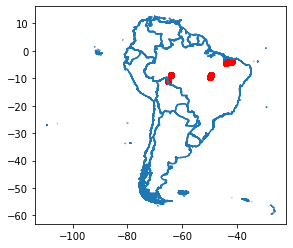

In [39]:
gdf_latam = gpd.read_file(la_map)
fig, ax = plt.subplots(1,1)
gdf_latam.boundary.plot(ax=ax)
gdf.plot(ax=ax, color="red")


In [55]:
complete_kml = []
incomplete_kml = []

for path in alert_in_brazil:
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    gdf = gpd.read_file(path, driver='KML')
    if gdf.shape[0] > 1:
        complete_kml.append(path)
    else:
        incomplete_kml.append(path)
    
print(f"From {len(alert_in_brazil)}, {len(complete_kml)} are complete.")

From 141, 0 are complete.


## Extracts Population

Currently an example with bangladesh


In [51]:
file_name = "0c5c7450b0ec461998b32b6c292e7443"
alert_path = os.path.join("data", "bangladesh", file_name, f"{file_name}.kml")
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
gdf = gpd.read_file(alert_path, driver='KML')
gdf.loc[gdf["Name"] == "aoi_polygon", "category"] = "base_polygon"
gdf.loc[gdf["Name"].str.contains("current"), "category"] = "current"
gdf.loc[gdf["Name"].str.contains("forecast"), "category"] = "forecast"
gdf.loc[gdf["Name"].str.contains("low"), "risk"] = 'low'
gdf.loc[gdf["Name"].str.contains("medium"), "risk"] = 'medium'
gdf.loc[gdf["Name"].str.contains("high"), "risk"] = 'high'
gdf.loc[gdf["Name"].str.contains("border"), "risk"] = "border"

bounds = gdf.bounds
miny = bounds["miny"].min()
maxy = bounds["maxy"].max()
minx = bounds["minx"].min()
maxx = bounds["maxx"].max()

gdf

,Name,Description,geometry,category,risk
0,aoi_polygon,,"POLYGON ((92.33810 25.05164, 92.33896 25.05074...",base_polygon,NaN
1,current_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",current,low
2,current_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",current,medium
3,current_high_risk_area,,"POLYGON ((92.33391 25.04486, 92.33493 25.04580...",current,high
4,current_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",current,border
5,forecast_0_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",forecast,low
6,forecast_0_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",forecast,medium
7,forecast_0_high_risk_area,,"POLYGON ((92.33446 25.04522, 92.33587 25.04739...",forecast,high
8,forecast_0_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",forecast,border


In [52]:
col = "general_population"
df_temp = pd.read_csv("demographic_data/bgd_general_2020.csv").rename(columns = {"bgd_general_2020": col})

delta = 0

print(f"General Before: {df_temp.shape[0]}")
# Filter
df_temp = df_temp[df_temp.latitude >= miny - delta]
df_temp = df_temp[df_temp.latitude <= maxy + delta]
df_temp = df_temp[df_temp.longitude >= minx - delta]
df_temp = df_temp[df_temp.longitude <= maxx + delta]

print(f"General After: {df_temp.shape[0]}")

gdf_general = gpd.GeoDataFrame(df_temp[[col]], geometry=gpd.points_from_xy(df_temp.longitude, df_temp.latitude), crs=gdf.crs)


gdf_temp = gpd.sjoin(left_df=gdf, right_df=gdf_general,  how="left", predicate="intersects")
gdf_temp = gdf_temp[[col]].reset_index()
gdf_temp = gdf_temp.groupby("index").sum()

gdf = gdf.merge(gdf_temp, left_index = True, right_index = True)
gdf

General Before: 13239037
General After: 23725


TypeError: sjoin() got an unexpected keyword argument 'predicate'

In [75]:
col_2 = "at_risk_population"
df_temp = pd.read_csv("demographic_data/bgd_elderly_60_plus_2020.csv")  .rename(columns = {"bgd_elderly_60_plus_2020": col_2})

delta = 0

print(f"At Risk Before: {df_temp.shape[0]}")
# Filter
df_temp = df_temp[df_temp.latitude >= miny - delta]
df_temp = df_temp[df_temp.latitude <= maxy + delta]
df_temp = df_temp[df_temp.longitude >= minx - delta]
df_temp = df_temp[df_temp.longitude <= maxx + delta]

print(f"At Risk After: {df_temp.shape[0]}")

gdf_at_risk = gpd.GeoDataFrame(df_temp[[col_2]], geometry=gpd.points_from_xy(df_temp.longitude, df_temp.latitude), crs=gdf.crs)


gdf_temp = gpd.sjoin(left_df=gdf, right_df=gdf_at_risk,  how="left", predicate="intersects")
gdf_temp = gdf_temp[[col_2]].reset_index()
gdf_temp = gdf_temp.groupby("index").sum()

gdf = gdf.merge(gdf_temp, left_index = True, right_index = True)
gdf


At Risk Before: 13239037
At Risk After: 23725


,Name,Description,geometry,category,risk,general_population,at_risk_population
0,aoi_polygon,,"POLYGON ((92.33810 25.05164, 92.33896 25.05074...",base_polygon,NaN,621017.449651,41706.435207
1,current_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",current,low,3229.083896,205.829346
2,current_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",current,medium,2737.701564,174.507489
3,current_high_risk_area,,"POLYGON ((92.33391 25.04486, 92.33493 25.04580...",current,high,2386.714184,152.134734
4,current_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",current,border,621535.822854,41739.384533
5,forecast_0_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",forecast,low,3229.083896,205.829346
6,forecast_0_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",forecast,medium,2737.701564,174.507489
7,forecast_0_high_risk_area,,"POLYGON ((92.33446 25.04522, 92.33587 25.04739...",forecast,high,2456.911660,156.609285
8,forecast_0_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",forecast,border,621535.822854,41739.384533


In [98]:
gdf["general_population_per"] = 100*gdf["general_population"]/gdf["general_population"].values[0]
gdf["at_risk_population_per"] = 100*gdf["at_risk_population"]/gdf["at_risk_population"].values[0]
gdf

,Name,Description,geometry,category,risk,general_population,at_risk_population,general_population_per,at_risk_population_per
0,aoi_polygon,,"POLYGON ((92.33810 25.05164, 92.33896 25.05074...",base_polygon,NaN,621017.449651,41706.435207,100.000000,100.000000
1,current_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",current,low,3229.083896,205.829346,0.519967,0.493519
2,current_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",current,medium,2737.701564,174.507489,0.440841,0.418419
3,current_high_risk_area,,"POLYGON ((92.33391 25.04486, 92.33493 25.04580...",current,high,2386.714184,152.134734,0.384323,0.364775
4,current_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",current,border,621535.822854,41739.384533,100.083472,100.079003
5,forecast_0_low_risk_area,,"POLYGON ((92.33335 25.04435, 92.33595 25.04703...",forecast,low,3229.083896,205.829346,0.519967,0.493519
6,forecast_0_medium_risk_area,,"POLYGON ((92.33280 25.04413, 92.33438 25.04500...",forecast,medium,2737.701564,174.507489,0.440841,0.418419
7,forecast_0_high_risk_area,,"POLYGON ((92.33446 25.04522, 92.33587 25.04739...",forecast,high,2456.911660,156.609285,0.395627,0.375504
8,forecast_0_border_risk_area,,"POLYGON ((92.02590 24.84203, 92.03489 24.84686...",forecast,border,621535.822854,41739.384533,100.083472,100.079003


In [103]:
vals = gdf.loc[[5,6,7,8],["general_population","at_risk_population","general_population_per","at_risk_population_per"]].values - gdf.loc[[1,2,3,4],["general_population","at_risk_population","general_population_per","at_risk_population_per"]].values

pd.DataFrame(vals, columns = ["general_population","at_risk_population","general_population_per","at_risk_population_per"])

,general_population,at_risk_population,general_population_per,at_risk_population_per
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,70.197476,4.474551,0.011304,0.010729
3,0.000000,0.000000,0.000000,0.000000


In [76]:
# change CRS for plotting
gdf_wm = gdf.to_crs(epsg=3857)
gdf_general_wm = gdf_at_risk.to_crs(epsg=3857)

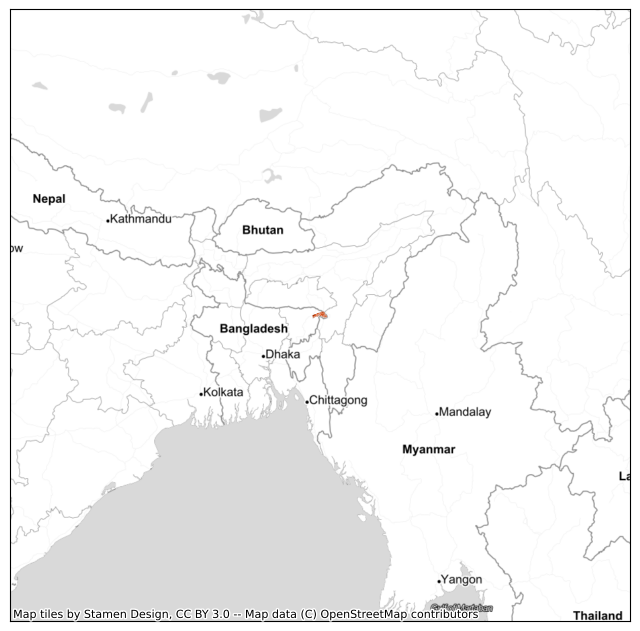

In [92]:

colors = {
    'low': "#f4ac90",
    'medium': "#e95d25",
    'high': "#942e05",
    'border': "#c9bbb5"
}

order = ["border","low", "medium", "high"]

# Zoom out by adding some

bounding_box = gdf_wm.loc[gdf_wm["category"] == "base_polygon"].bounds
zoom_out = bounding_box.values[0]

x_zoom = 1000000
y_zoom = 1000000

zoom_out = gpd.GeoSeries([Point(zoom_out[0] - x_zoom, zoom_out[1] - y_zoom),
                        Point(zoom_out[0] - x_zoom, zoom_out[3] + y_zoom), 
                        Point(zoom_out[2] + x_zoom, zoom_out[3] + y_zoom),
                        Point(zoom_out[2] + x_zoom, zoom_out[1] - y_zoom)])

ax2 = zoom_out.plot(alpha=0, figsize=(8, 8))

for s in order:
    gdf_wm.loc[(gdf_wm["category"] == "current") & (gdf_wm["risk"] == s)].plot(ax=ax2, color=colors[s], linewidth=0.5)


cx.add_basemap(ax2, source=cx.providers.Stamen.TonerLite)
plt.tick_params(left = False, right = False , labelleft = False,labelbottom = False, bottom = False)


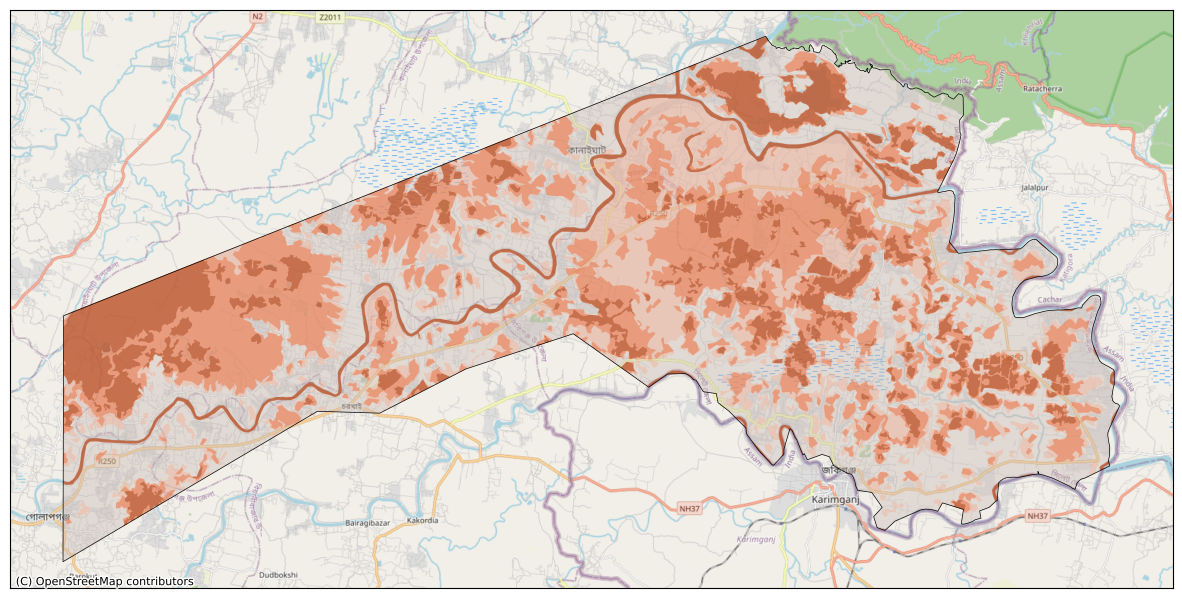

In [97]:
colors = {
    'low': "#f4ac90",
    'medium': "#e95d25",
    'high': "#942e05",
    'border': "#c9bbb5"
}

order = ["border","low", "medium", "high"]

# Zoom out by adding some

bounding_box = gdf_wm.loc[gdf_wm["category"] == "base_polygon"].bounds
zoom_out = bounding_box.values[0]

x_zoom = 1000000
y_zoom = 1000000

zoom_out = gpd.GeoSeries([Point(zoom_out[0] - x_zoom, zoom_out[1] - y_zoom),
                        Point(zoom_out[0] - x_zoom, zoom_out[3] + y_zoom), 
                        Point(zoom_out[2] + x_zoom, zoom_out[3] + y_zoom),
                        Point(zoom_out[2] + x_zoom, zoom_out[1] - y_zoom)])

ax1  = gdf_wm.loc[gdf_wm["category"] == "base_polygon"].boundary.plot(color="k", linewidth=0.5, figsize=(15, 10))

for s in order:
    gdf_wm.loc[(gdf_wm["category"] == "current") & (gdf_wm["risk"] == s)].plot(ax=ax1, color=colors[s], linewidth=0.5, alpha=0.4)


cx.add_basemap(ax1, source=cx.providers.OpenStreetMap.Mapnik)
plt.tick_params(left = False, right = False , labelleft = False,labelbottom = False, bottom = False)



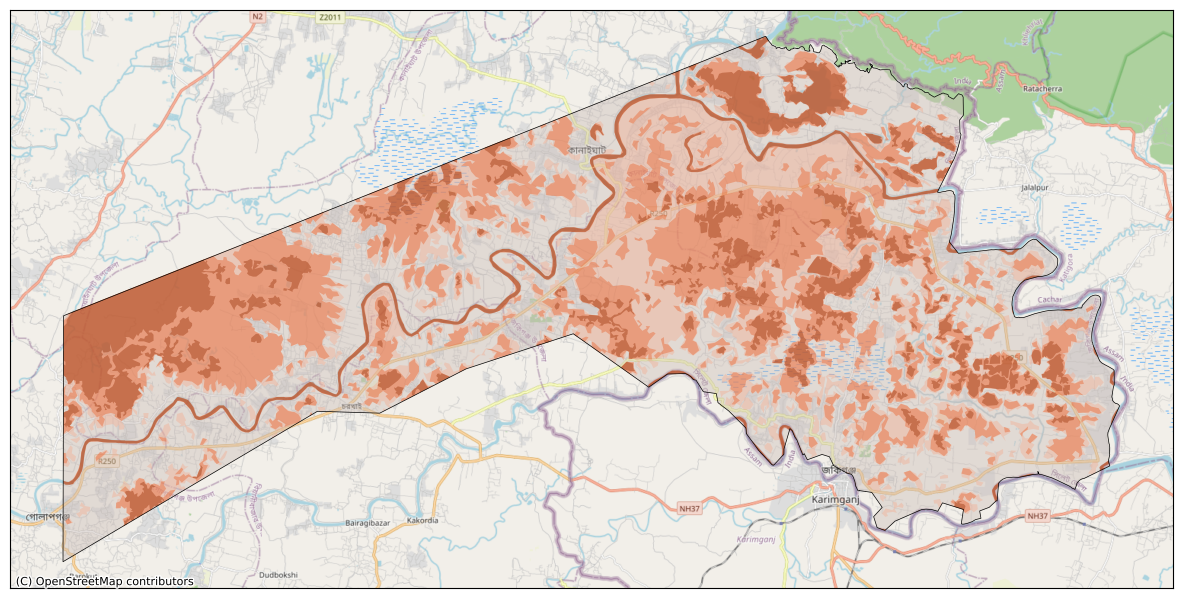

In [99]:

colors = {
    'low': "#f4ac90",
    'medium': "#e95d25",
    'high': "#942e05",
    'border': "#c9bbb5"
}

order = ["border","low", "medium", "high"]

# Zoom out by adding some

bounding_box = gdf_wm.loc[gdf_wm["category"] == "base_polygon"].bounds
zoom_out = bounding_box.values[0]

x_zoom = 1000000
y_zoom = 1000000

zoom_out = gpd.GeoSeries([Point(zoom_out[0] - x_zoom, zoom_out[1] - y_zoom),
                        Point(zoom_out[0] - x_zoom, zoom_out[3] + y_zoom), 
                        Point(zoom_out[2] + x_zoom, zoom_out[3] + y_zoom),
                        Point(zoom_out[2] + x_zoom, zoom_out[1] - y_zoom)])

ax1 = gdf_wm.loc[gdf_wm["category"] == "base_polygon"].boundary.plot(color="k", linewidth=0.5, figsize=(15, 10))

for s in order:
    gdf_wm.loc[(gdf_wm["category"] == "forecast") & (gdf_wm["risk"] == s)].plot(ax=ax1, color=colors[s], linewidth=0.5, alpha=0.4)

cx.add_basemap(ax1, source=cx.providers.OpenStreetMap.Mapnik)
plt.tick_params(left = False, right = False , labelleft = False,labelbottom = False, bottom = False)

In [62]:
list = []
for i in range(1, 24):
    list.append(str(i))

" ".join(list)


'1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23'

In [ ]:
True,True,True,True,True